In [1]:
import kan
import kan.utils as ku
import numpy as np
import torch.nn as nn
import torch
import qutip as qt
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions

In [2]:
def rfft(x):
    x = (-1) ** np.array(x)
    return np.fft.rfft(x)[1:]

In [3]:
N=10; J1=1; J2=0
gs10 = qt.qload('../J1J2_info/N10/n10gs_J2_0.0')
gs10

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape=(1024, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 1.26928255e-48]
 [-2.63794454e-18]
 ...
 [ 1.20393997e-48]
 [-2.12190686e-48]
 [ 0.00000000e+00]]

In [4]:
states, signs = utils.get_nonzero_states(N, gs10, 1e-10)
input = utils.generate_input_samples(N, states)
print(input.shape)
ft_input = []
for x in input:
    amp_phase = []
    ft = rfft(x)
    for c in ft:
        amp_phase.append(np.abs(c))
        amp_phase.append(np.angle(c) % (2 * np.pi))
    ft_input.append(amp_phase)
ft_input = torch.tensor(ft_input)
print(ft_input.shape)
msr_label = torch.tensor([magnetization.count_half_magnetization(s) for s in states]).reshape(-1, 1)
sign_label = torch.tensor(signs).reshape(-1, 1)
print(msr_label.shape, sign_label.shape)
msr_dataset = {'train_input':ft_input, 'train_label':msr_label, 'test_input':ft_input, 'test_label':msr_label}
sign_dataset = {'train_input':ft_input, 'train_label':sign_label, 'test_input':ft_input, 'test_label':sign_label}

torch.Size([252, 10])
torch.Size([252, 10])
torch.Size([252, 1]) torch.Size([252, 1])


In [14]:
def generate_loss(gs, states):
    def weighted_loss(x, y):
        return torch.sum(abs(torch.tensor(gs.full()[states, :])) ** 2 * (x - y) ** 2)
    return weighted_loss

In [52]:
gs10.full()[states, :]

array([[ 0.0004815 +0.j],
       [-0.00289646-0.j],
       [ 0.0063674 +0.j],
       [-0.0063674 -0.j],
       [ 0.00289646+0.j],
       [-0.0004815 -0.j],
       [ 0.0063674 +0.j],
       [-0.02425722-0.j],
       [ 0.03034962+0.j],
       [-0.01583777-0.j],
       [ 0.00289646+0.j],
       [ 0.01788982+0.j],
       [-0.04534298-0.j],
       [ 0.03034962+0.j],
       [-0.0063674 -0.j],
       [ 0.01788982+0.j],
       [-0.02425722-0.j],
       [ 0.0063674 +0.j],
       [ 0.0063674 +0.j],
       [-0.00289646-0.j],
       [ 0.0004815 +0.j],
       [-0.0063674 -0.j],
       [ 0.03034962+0.j],
       [-0.04844595-0.j],
       [ 0.03034962+0.j],
       [-0.0063674 -0.j],
       [-0.04534298-0.j],
       [ 0.13383286+0.j],
       [-0.10348324-0.j],
       [ 0.02425722+0.j],
       [-0.06450766-0.j],
       [ 0.10348324+0.j],
       [-0.03034962-0.j],
       [-0.03034962-0.j],
       [ 0.01583777+0.j],
       [-0.00289646-0.j],
       [ 0.01788982+0.j],
       [-0.06450766-0.j],
       [ 0.0

In [16]:
kan10 = kan.KAN(width=[10, 1, 1])
kan10.fit(sign_dataset, steps=50, lamb=1e-3, loss_fn = generate_loss(gs10, states));

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 4.71e-03 | test_loss: 3.79e-03 | reg: 6.11e+00 | : 100%|█| 50/50 [00:06<00:00,  7.74it

saving model version 0.1


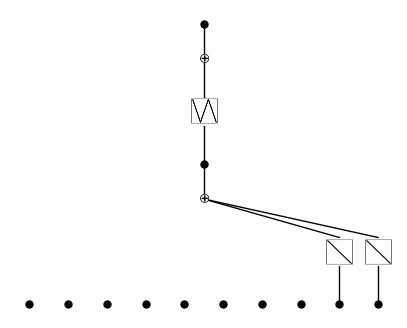

In [17]:
kan10.plot()

In [18]:
kan10.fix_symbolic(0, 8, 0, 'x');
kan10.fix_symbolic(0, 9, 0, 'x');
kan10.fix_symbolic(1, 0, 0, 'cos');
kan10.fit(sign_dataset, steps=20);

r2 is 0.9999781847000122
saving model version 0.2
r2 is 1.0000008344650269
saving model version 0.3
r2 is 0.9999974966049194
saving model version 0.4


| train_loss: 5.43e-05 | test_loss: 5.43e-05 | reg: 7.23e-02 | : 100%|█| 20/20 [00:01<00:00, 13.15it

saving model version 0.5


In [19]:
ku.ex_round(kan10.symbolic_formula()[0][0], 3)

c:\Users\taoha\anaconda3\envs\kans\lib\site-packages\sympy\core\sympify.py:475: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  return sympify(float(a))


-1.002*cos(0.958*x_10 + 0.783*x_9 + 4.806)

In [118]:
J2 = 0.2
gs = qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_0.2')
states, signs = utils.get_nonzero_states(N, gs, 1e-10)
sign_label = torch.tensor(signs).reshape(-1, 1)
finite_signs = {'train_input':ft_input, 'train_label':sign_label, 'test_input':ft_input, 'test_label':sign_label}

In [119]:
kanf = kan.KAN(width=[10, 1, 1])
kanf.fit(finite_signs, lamb=0, steps=50, loss_fn=generate_loss(gs, states));

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 7.74e-02 | test_loss: 1.30e-01 | reg: 9.50e+00 | : 100%|█| 50/50 [00:05<00:00,  9.95it

saving model version 0.1


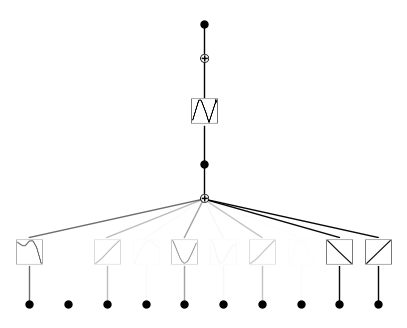

In [120]:
kanf.plot()

saving model version 0.2


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 1.35e-04 | test_loss: 1.59e-04 | reg: 8.49e+00 | : 100%|█| 50/50 [00:04<00:00, 10.46it


saving model version 0.3


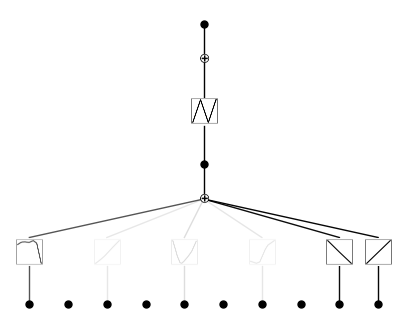

In [121]:
kanf = kanf.prune()
kanf.fit(finite_signs, lamb=0, steps=50, loss_fn=generate_loss(gs, states));
kanf.plot()

In [122]:
kanf.suggest_symbolic(1, 0, 0, topk=10, weight_simple=0.3);

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       sin    1.000000 -16.680128           2                2  -11.076089
1       cos    1.000000 -16.680128           2                2  -11.076089
2       tan    0.994246  -7.438790           3                3   -4.307153
3  gaussian    0.984248  -5.987377           3                3   -3.291164
4     1/x^2    0.963765  -4.786056           2                2   -2.750239
5       1/x    0.950998  -4.350725           2                2   -2.445507
6     1/x^3    0.960056  -4.645508           3                3   -2.351856
7       abs    0.939109  -4.037382           3                3   -1.926168
8     1/x^4    0.949284  -4.301140           4                4   -1.810798
9     1/x^5    0.945277  -4.191448           5                5   -1.434013


r2 is 1.0000004768371582
saving model version 0.4
Best value at boundary.
r2 is 0.9999443888664246
saving model version 0.5
r2 is 1.000001311302185
saving model version 0.6


| train_loss: 1.65e-05 | test_loss: 1.33e-04 | reg: 2.68e+00 | : 100%|█| 50/50 [00:08<00:00,  5.85it


saving model version 0.7


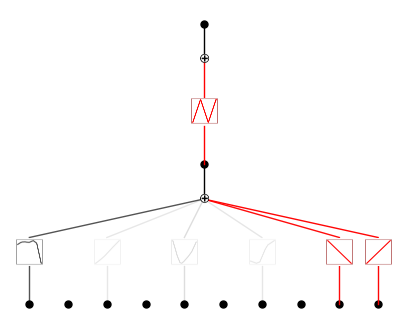

In [123]:
kanf.fix_symbolic(1, 0, 0, 'cos');
kanf.fix_symbolic(0, 8, 0, 'x');
kanf.fix_symbolic(0, 9, 0, 'x');
kanf.fit(finite_signs, lamb=0, steps=50, loss_fn=generate_loss(gs, states));
kanf.plot()

| train_loss: 5.42e-03 | test_loss: 1.30e-02 | reg: 1.39e+00 | : 100%|█| 50/50 [00:15<00:00,  3.13it


saving model version 0.8


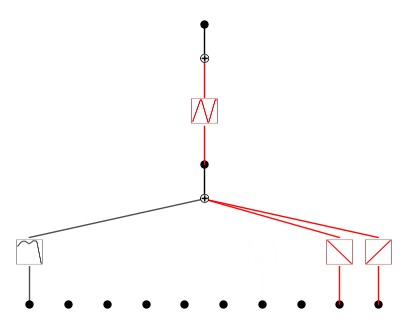

In [126]:
kanf.fit(finite_signs, lamb=1e-3, steps=50, loss_fn=generate_loss(gs, states));
kanf.plot()

saving model version 0.9


| train_loss: 6.09e-02 | test_loss: 6.58e-02 | reg: 1.74e-01 | : 100%|█| 50/50 [00:14<00:00,  3.45it


saving model version 0.10


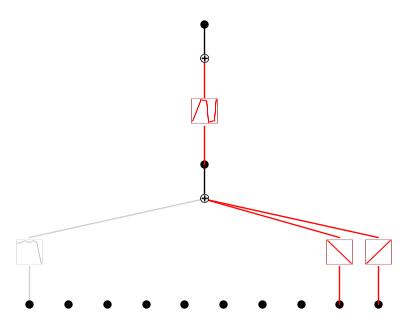

In [127]:
kanf = kanf.prune()
kanf.fit(finite_signs, lamb=1e-2, steps=50, loss_fn=generate_loss(gs, states));
kanf.plot()

In [128]:
ku.ex_round(kanf.symbolic_formula()[0][0], 4)

-3.0631*cos(-1.0033*x_10 + 0.78*x_9 + 5.1352) - 0.03

In [133]:
kanf.suggest_symbolic(0, 0, 0, topk=10, weight_simple=0.3);

    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        tan    0.981942 -5.790386           3                3   -3.153270
1        exp    0.970582 -5.086650           2                2   -2.960655
2      1/x^2    0.969287 -5.024528           2                2   -2.917169
3        1/x    0.968650 -4.994949           2                2   -2.896464
4    1/x^0.5    0.968562 -4.990866           2                2   -2.893606
5  1/sqrt(x)    0.968562 -4.990866           2                2   -2.893606
6   gaussian    0.971324 -5.123508           3                3   -2.686455
7       tanh    0.970370 -5.076316           3                3   -2.653421
8      1/x^3    0.969290 -5.024698           3                3   -2.617289
9        sgn    0.968552 -4.990418           3                3   -2.593293


In [124]:
ku.ex_round(kanf.symbolic_formula()[0][0], 4)

-1.001*cos(-1.0*x_10 + 0.756*x_9 + 4.2898)

r2 is 0.9705816507339478
saving model version 0.11


| train_loss: 1.91e-02 | test_loss: 1.32e-02 | reg: 0.00e+00 | : 100%|█| 50/50 [00:06<00:00,  7.28it


saving model version 0.12


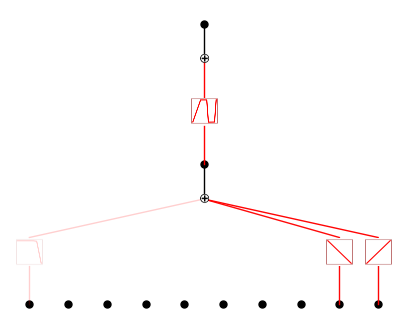

In [134]:
kanf.fix_symbolic(0, 0, 0, 'exp');
kanf.fit(finite_signs, lamb=0, steps=50, loss_fn=generate_loss(gs, states));
kanf.plot()

In [135]:
ku.ex_round(kanf.symbolic_formula()[0][0], 4)

0.0027 - 3.0631*cos(-1.0006*x_10 + 0.7864*x_9 + 5.9455)

In [136]:
print(generate_loss(gs, states)(finite_signs['train_label'], torch.cos(ft_input[:, [9]] + ft_input[:, [8]] * np.pi / 4 + np.pi / 2)).item())
print(generate_loss(gs, states)(finite_signs['train_label'], kanf(ft_input)).item())

1.0626982664433065e-07
0.00010104475903865892


In [ ]:
kanf4 = 